<a href="https://colab.research.google.com/github/shokru/coqueret.github.io/blob/master/stacked_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stacked models: theoretical illustration

This notebook shows the impact of intermediate supervision on the outcome of a predictive pipeline. It illustrates a paper by Guillaume Coqueret, Cyrille Henry-Bonniot and Thomas Raffinot.

First, we start by loading the required packages.

In [18]:
from sklearn import datasets
import matplotlib.pyplot as plt
import copy
import numpy as np
import sklearn
import pandas as pd
import lightgbm as lgb
import warnings

Next, we define the learning function. It is based on **lightGBM**: https://lightgbm.readthedocs.io/en/latest/.  
Because we do not want to overfit, we stick to the default training parameters & resort to cross-validation.   
The loss function is the **root mean squared error**. 

In [19]:
def run_lightGBM(X,
                 y,
                 train,
                 test,
                 FIXED_PARAMS,
                 SEARCH_PARAMS,
                 weights):
    """
    compute lightGBM.
    Returns:
        - the predictions
        - the model
        - the eval metric

    Parameters
    ----------
    X: pd.dataframe = table of regressors
    y: pd.Series = target
    train: List = indices of the training sample
    test: List = indices of the test sample

    FIXED_PARAMS: dict
    dictionary of lightGBM parameters (not optimized)

    SEARCH_PARAMS: dict
    dictionary of lightGBM parameters (optimized)

    weights: pd.Series
    weights of each observations
    ----------
    """
    warnings.filterwarnings("ignore")
    Xtrain = X[train, :]
    Xtest = X[test, :]

    if weights.size > 0:
        train_data = lgb.Dataset(Xtrain, label=y[train], weight=weights[train], silent=True)
        valid_data = lgb.Dataset(Xtest, label=y[test],
                                 reference=train_data, weight=weights[test], silent=True)
    else:
        train_data = lgb.Dataset(Xtrain, label=y[train], silent=True)
        valid_data = lgb.Dataset(Xtest, label=y[test], reference=train_data,
                                 silent=True)
    if len(SEARCH_PARAMS) > 0:
        params = {**FIXED_PARAMS,
                  **SEARCH_PARAMS,
                  'verbose': -1}
    else:
        params = {**FIXED_PARAMS,
                  'verbose': -1}
    model = lgb.train(params,
                      train_data,
                      verbose_eval=False,
                      valid_sets=[valid_data],
                      valid_names=['validation'])
    preds = model.predict(Xtest)
    scores = model.best_score['validation'][FIXED_PARAMS['metric']]
    return preds, model, scores

The main function accepts 2 methods: the direct one and the indirect one:
- the **direct** method takes the predictors and uses them directly in a boosted tree algorithm;  
- the **indirect** method first processes the predictors via a set of intermediate labels: this yields a new training set and the final model uses the new variables as predictors.

To illustrate the relevance of this approach, we will use two types of indirect approaches: one that improve accuracy and one that deteriorates it. 

In [20]:
def friedman(y,
             X,
             fixedparam_lgbm,
             d_param,
             n_split=10,
             method="direct"):
    """
    run cross validations of lightGBM.
        - If method is "indirect-*", compute run_lightGBM for all targets in y.
          y[y] if supposed to be the final target. All others are intermediate targets
        - If method is "direct", run run_lightGBM only for y[y]
    Returns:
        - lRes: dict with predictions/model/metric for each targets in y
        - metric: eval metric for the final target

    Parameters
    ----------
    y: dict = dictionary of targets
    X: pd.dataframe = table of regressors

    fixedparam_lgbm: dict
    dictionary of lightGBM parameters (not optimized)

    d_param: dict
    dictionary of lightGBM parameters (optimized)

    n_split: integer
    number of sample splits for the cross validation

    method: string
        - direct: y[y] is learnt directly
        - indirect-1: y[y] is learnt based on predictions of intermediate targets
        - indirect-2: y[y] is learnt based on predictions of intermediate targets and original regressors
    ----------
    """
    lRes = dict()
    if method == "indirect":
        y_firstLayer = copy.deepcopy(y)
        del y_firstLayer["y"]
        kf = sklearn.model_selection.KFold(n_splits=n_split)
        # First layer:
        for ML in y_firstLayer:
            res = pd.DataFrame((run_lightGBM(X,
                                             y[ML],
                                             train,
                                             test,
                                             fixedparam_lgbm,
                                             d_param[ML],
                                             np.array([])) for train, test in kf.split(X))
                               )   # returns [scores, preds, model]
            lRes[ML] = np.concatenate(res[0].to_list(), axis=0)
    # Second layer:
    ML = "y"
    # Construction of predictors
    if method == "indirect":
        Xintermediate = np.transpose(np.array(list(lRes.values())))  # aggregation of CV predictions
    elif method == "direct":
        Xintermediate = X
    kf = sklearn.model_selection.KFold(n_splits=n_split)
    res = pd.DataFrame((run_lightGBM(Xintermediate,
                                     y[ML],
                                     train,
                                     test,
                                     fixedparam_lgbm,
                                     d_param[ML],
                                     np.array([])) for train, test in kf.split(X))
                       )  # returns [scores, preds, model]
    lRes[ML] = np.concatenate(res[0].to_list(), axis=0)
    metric = res[2].mean()
    return lRes[ML], metric

We are then ready to proceed.  
The data generating process is given by the **Friedman function**, which depends on 6 variables:
$$f(x_0,\dots,x_5)=10\sin(\pi x_0x_1)+(x_2-0.5)^2+10x_3+5x_4.$$
Note that the last variable is included but does not drive the function: it is useless for prediction purposes. The label is then the sum of the Friedman function plus some white noise:
$$y = f(x_0,\dots,x_5)+ \sigma \epsilon,$$
where $ϵ$ is a standrard Gaussian ($N(0,1)$) variable.  
Below, we test different values for **learning sample size** and **noise**.  

In [21]:
vN = [100, 1000, 10000, 100000]  # size of the learning sample
vNoise = [0, 1]                  # noise to add to the Friedman function
n_features = 6                   # number of regressors (the last one is useless to predict y)
fixedparam_lgbm = {'objective': 'rmse',
                   'metric': 'rmse'}
D_metric = np.zeros([len(vN), len(vNoise)])
I1_metric = np.zeros([len(vN), len(vNoise)])
I2_metric = np.zeros([len(vN), len(vNoise)])
for i in range(len(vN)):
    for j in range(len(vNoise)):
        N = vN[i]
        noise = vNoise[j]
        np.random.seed(seed=0)
        X = np.random.uniform(size=(N, n_features))
        ya = 10 * np.sin(np.pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 + 10 * X[:, 3] + 5 * X[:, 4]
        y = ya + noise * np.random.normal(N)
        Y = {"y": y}

        # Prediction of the Friedman function directly
        _, D_metric[i, j] = friedman(Y,
                                     X,
                                     fixedparam_lgbm,
                                     dict(zip(Y.keys(), [''] * len(Y))),
                                     n_split=5,
                                     method="direct")
        
        # Prediction of the Friedman function with USEFUL intermediate targets
        y1 = 10 * np.sin(np.pi * X[:, 0] * X[:, 1]) + noise / np.sqrt(3) * np.random.normal(N)
        y2 = 20 * (X[:, 2] - 0.5) ** 2 + noise / np.sqrt(3) * np.random.normal(N)
        y3 = 10 * X[:, 3] + 5 * X[:, 4] + noise / np.sqrt(3) * np.random.normal(N)   
        Y = {"y": y, "y1": y1, "y2": y2, "y3": y3}  # enter the target y and the intermediate targets you wish to use        
        _, I1_metric[i, j] = friedman(Y,
                                     X,
                                     fixedparam_lgbm,
                                     dict(zip(Y.keys(), [''] * len(Y))),
                                     n_split=5,
                                     method="indirect")
        
        #  prediction of the Friedman function with USELESS intermediate targets
        y1 = 10 *  X[:, 0] * X[:, 1] + noise / np.sqrt(3) * np.random.normal(N)
        y2 = 20 * (X[:, 2]) ** 2 + noise / np.sqrt(3) * np.random.normal(N)
        y3 = X[:, 3]  * X[:, 4] + noise / np.sqrt(3) * np.random.normal(N)   
        Y = {"y": y, "y1": y1, "y2": y2, "y3": y3}  # enter the target y and the intermediate targets you wish to use          
        _, I2_metric[i, j] = friedman(Y,
                                     X,
                                     fixedparam_lgbm,
                                     dict(zip(Y.keys(), [''] * len(Y))),
                                     n_split=5,
                                     method="indirect")
        # indirect-1 only uses the predictions from the intermediate targets to predict the final target
        # indirect-2 includes the original regressors.

We can then plot the results. 

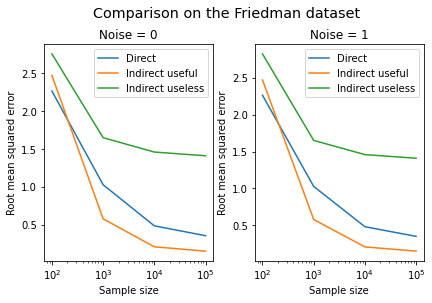

In [22]:
if len(vNoise) > 1:
    fig, ax = plt.subplots(1, len(vNoise))
    plt.tight_layout()
    for i in range(len(vNoise)):
        ax[i].plot(vN, D_metric[:, i])
        ax[i].plot(vN, I1_metric[:, i])
        ax[i].plot(vN, I2_metric[:, i])
        ax[i].set_title("Noise = " + str(vNoise[i]))
        ax[i].legend(["Direct", "Indirect useful", "Indirect useless"])
        ax[i].set_xscale("log")
        ax[i].set_xlabel("Sample size")
        ax[i].set_ylabel("Root mean squared error")
    fig.suptitle("Comparison on the Friedman dataset", fontsize="x-large")
    fig.subplots_adjust(top=0.85)
else:
    fig, ax = plt.subplots()
    plt.tight_layout()
    ax.plot(vN, D_metric[:, 0])
    ax.plot(vN, I1_metric[:, 0], '--')
    ax.plot(vN, I2_metric[:, 0], '-+')
    ax.set_title("Noise = " + str(vNoise[0]))
    ax.legend(["Direct", "Indirect useful", "Indirect useless"])
    ax.set_xscale("log")
    ax.set_xlabel("Sample size")
    ax.set_ylabel("Root mean squared error")
    fig.suptitle("Comparison on the Friedman dataset", fontsize="x-large")
    fig.subplots_adjust(top=0.85)
